# Serial Position Experiments

Serial key-value associative retrieval task

Assess performance for items at different positions in the list

In [106]:
import sys, random, uuid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
import torch
from transformers import pipeline

# for running on colab
if 'google.colab' in sys.modules:
    !git clone https://github.com/sflippl/models-of-memory.git
    sys.path.append('models-of-memory')
    dir = 'models-of-memory'
else:
    print("Running locally")
    dir = '.'

Running locally


In [55]:
def generate_stimuli(list_length=100, type='uuid'):
    if 'uuid' in type:
        return [str(uuid.uuid4()) for _ in range(list_length*2)]
    elif 'word' in type:
        with open(f'{dir}/_data/wasnorm_wordpool.txt', 'r', encoding='utf-8') as f:
            all_words = [line.strip().lower() for line in f.readlines()]
        return np.random.choice(all_words, list_length*2, replace=False)

def generate_prompt(all_stimuli, query_index):
    keys = all_stimuli[:len(all_stimuli)//2]
    values = all_stimuli[len(all_stimuli)//2:]
    prompt = "Extract the value corresponding to the specified key in the pairs below.\n\n{"
    for k,v in zip(keys, values):
        prompt += f"\"{k}\": \"{v}\"\n"
    prompt = prompt[:-2] + "}\n\n" # take off last \n
    prompt += f"Key: \"{keys[query_index]}\"\n"
    prompt += "Corresponding value: "
    return prompt


def make_pipe(model_id):
    pipe = pipeline("text-generation", model=model_id, dtype=torch.bfloat16, device_map="auto")
    return pipe

def query_model(pipe, inp):
    messages = [{"role": "user", "content": inp}]
    all_outputs = pipe(messages, max_new_tokens=256, temperature=0.7, top_p=0.8, top_k=20,min_p=0.1)
    output = all_outputs[0]['generated_text'][-1]['content'].strip().lower()
    return output, all_outputs

In [ ]:
pipe = make_pipe(model_id="Qwen/Qwen3-4B-Instruct-2507")

In [ ]:
list_length = 300
stims = generate_stimuli(list_length, type='uuids')

In [ ]:
n_experiments = 100
position_accuracy = np.zeros(list_length)
item_accuracy = defaultdict(int)

# FIGURE OUT CACHING
for _ in tqdm(range(n_experiments)):
    stimuli = generate_stimuli(n=list_length, type='uuid')
    for query_index in range(list_length):
        prompt = generate_prompt(stimuli, query_index)
        output, _ = pipe(prompt)
        target_stimulus = stimuli[query_index]
        position_accuracy[query_index] += output == target_stimulus
        item_accuracy[target_stimulus] += output == target_stimulus
        
position_accuracy /= n_experiments
for k, v in item_accuracy.items():
    item_accuracy[k] = v / n_experiments
item_accuracy = dict(item_accuracy)

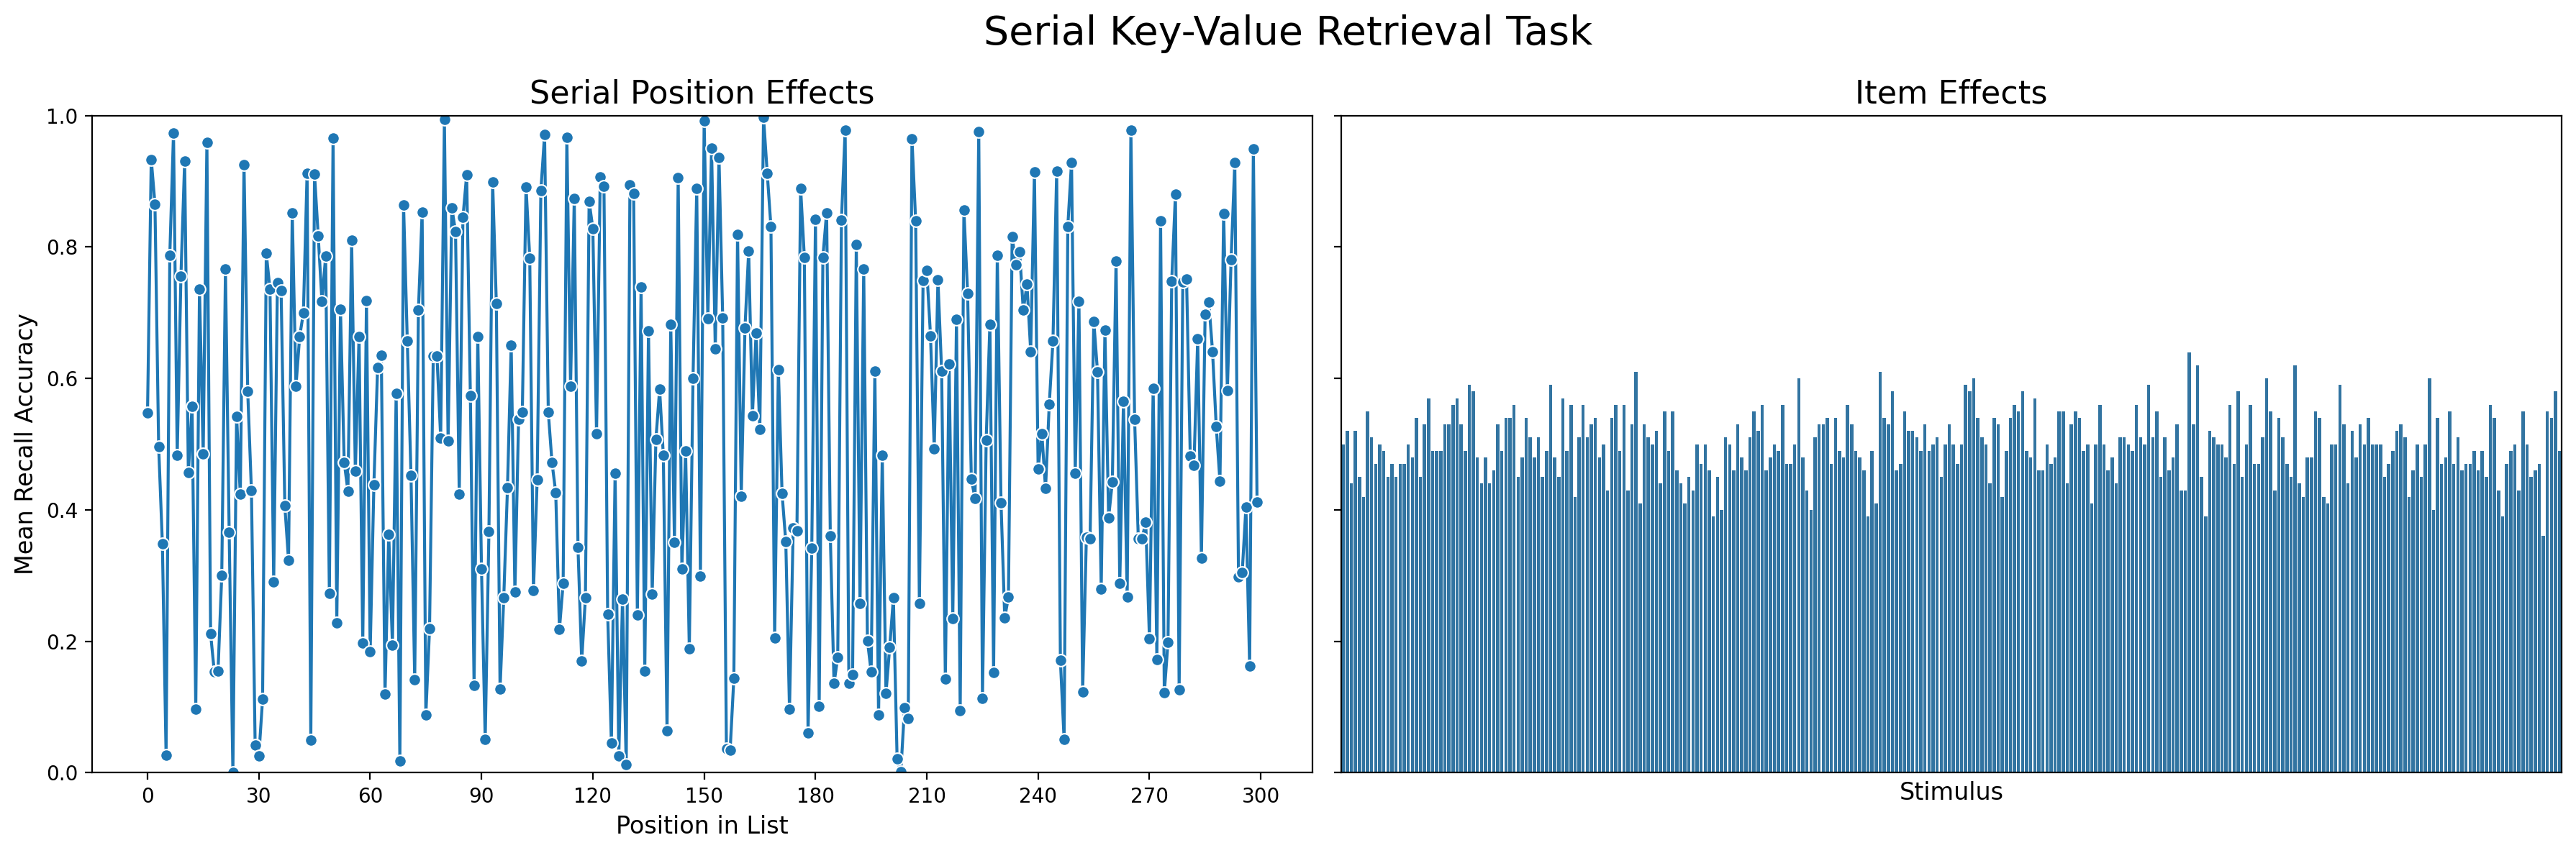

In [105]:
fig, ax = plt.subplots(1,2, figsize=(18,6), sharey=True, dpi=200)
plt.suptitle('Serial Key-Value Retrieval Task',fontsize=20)
ax[0].set_title('Serial Position Effects', fontsize=16)
sns.lineplot(position_accuracy, marker='o', ax=ax[0])
ax[0].set_xlabel('Position in List', fontsize=12)
ax[0].set_ylabel('Mean Recall Accuracy', fontsize=12)
ax[0].set_xticks(np.linspace(0, list_length, 11))
ax[0].set_ylim(0, 1) # Accuracy is between 0 and 1
sns.barplot(x=item_accuracy.keys(), y=item_accuracy.values(), ax=ax[1])
ax[1].set_title('Item Effects', fontsize=16)
ax[1].set_xlabel('Stimulus', fontsize=12)
ax[1].set_xticks([])
# ax[1].set_xticks(np.arange(len(item_accuracy)), labels=list(item_accuracy.keys()),rotation=45)
plt.tight_layout()
plt.show()
